In [83]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [84]:
pd.set_option('display.max_rows', 500)

In [85]:
df_dem = pd.read_csv("../archive/Demographics/demographics.csv")
df_survey = pd.read_csv("../archive/all_student_ema_data_cleaned (1).csv")
df_sens = pd.read_csv("../archive/Sensing/sensing.csv")

In [86]:
df_survey['day'] = pd.to_datetime(df_survey['day'], format='%Y%m%d')
df_sens['day'] = pd.to_datetime(df_sens['day'], format='%Y%m%d')
df_survey = df_survey.drop(columns=['Unnamed: 0'])

In [87]:
df_sens['OS'] = df_sens.is_ios.apply(lambda x: 'iOS' if x else 'Android')

In [88]:
def calculate_cohort_year(date):
    if date.month >= 9:
        return date.year
    else:
        return date.year - 1

cohort_year = df_survey.groupby('uid')['day'].min().reset_index()
cohort_year.columns = ['uid', 'first_day']
cohort_year['cohort_year'] = cohort_year['first_day'].apply(calculate_cohort_year).astype(int)
cohort_year = cohort_year.drop(columns=['first_day'])

In [89]:
cols = [
    'uid',
    'day',
    'OS',
    'is_ios',
    # physical
    'act_on_foot_ep_0',
    'act_running_ep_0',
    'act_walking_ep_0',
    'loc_study_dur',
    'loc_home_dur',
    'loc_workout_dur',
    # social
    'act_in_vehicle_ep_0',
    'loc_dist_ep_0',
    'loc_social_dur',
    'loc_food_dur',
    'loc_visit_num_ep_0',
    'loc_social_unlock_duration',
    'loc_food_unlock_duration',
    'loc_social_unlock_num',
    'loc_food_unlock_num',
    'loc_social_still',
    'loc_food_still',
    # sleep
    'sleep_duration',
    'sleep_start',
    'sleep_end',
]
df_sens = df_sens[cols].copy()

In [90]:
def sum_skipna(row, col1, col2):
    if np.isnan(row[col1]) and np.isnan(row[col2]):
        return np.nan
    elif np.isnan(row[col1]) and not np.isnan(row[col2]):
        return row[col2]
    elif not np.isnan(row[col1]) and np.isnan(row[col2]):
        return row[col1]
    else:
        return row[col1] + row[col2]

In [91]:
df_sens['24_minus_loc_home_dur'] = 24 - df_sens['loc_home_dur']

df_sens['act_running_ep_0_plus_act_walking_ep_0'] = df_sens.apply(
    lambda x: sum_skipna(x, 'act_running_ep_0', 'act_walking_ep_0'), axis=1)
df_sens['loc_social_dur_plus_loc_food_dur'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_dur', 'loc_food_dur'), axis=1)
df_sens['loc_social_unlock_duration_plus_loc_food_unlock_duration'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_unlock_duration', 'loc_food_unlock_duration'), axis=1)
df_sens['loc_social_unlock_num_plus_loc_food_unlock_num'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_unlock_num', 'loc_food_unlock_num'), axis=1)
df_sens['loc_social_still_plus_loc_food_still'] = df_sens.apply(
    lambda x: sum_skipna(x, 'loc_social_still', 'loc_food_still'), axis=1)
df_sens['act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0'] = df_sens.loc[df_sens['OS'] == 'Android', 'act_on_foot_ep_0']
df_sens['act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0'] = df_sens.loc[df_sens['OS'] == 'iOS', 'act_running_ep_0_plus_act_walking_ep_0']

In [92]:
# check if sum_skipna works as intended
# df_sens[['loc_social_unlock_duration', 'loc_food_unlock_duration', 'loc_social_unlock_duration_plus_loc_food_unlock_duration']].head(100)

In [93]:
TK = 10

In [94]:
%%time
merged_list = []

for i, uid in enumerate(df_dem['uid'].unique()):
    # print(f"{i+1} / {len(df_dem['uid'].unique())}")
    df_survey_uid = df_survey[df_survey['uid'] == uid]
    df_sens_uid = df_sens[df_sens['uid'] == uid]

    df_merged = df_survey_uid.merge(df_sens_uid, how='cross', suffixes=('_survey', '_sens'))
    df_filtered = df_merged[
        (df_merged['day_sens'] >= df_merged['day_survey'] - timedelta(days=TK)) &
        (df_merged['day_sens'] <= df_merged['day_survey'] - timedelta(days=1))
    ]
    merged_list.append(df_filtered)


CPU times: user 5.43 s, sys: 1.49 s, total: 6.93 s
Wall time: 7.07 s


In [95]:
df_merged = pd.concat(merged_list).reset_index(drop=True)

In [96]:
df_merged[['uid_survey', 'uid_sens', 'day_survey', 'day_sens']]

,uid_survey,uid_sens,day_survey,day_sens
0,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-09,2017-09-08
1,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,2017-09-08
2,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,2017-09-09
3,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-14,2017-09-08
4,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-14,2017-09-09
...,...,...,...,...
337578,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-19
337579,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-20
337580,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-21
337581,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-22


In [97]:
df_merged['diff_days'] = df_merged.day_survey - df_merged.day_sens

In [98]:
df_merged.diff_days.value_counts()

diff_days
1 days     34520
2 days     34181
3 days     34007
4 days     33888
5 days     33788
6 days     33656
7 days     33542
8 days     33425
9 days     33347
10 days    33229
Name: count, dtype: int64

In [99]:
df_merged.head(1).T

,0
uid_survey,3569e2f520db9014b4acc4227a6421c1
day_survey,2017-09-09 00:00:00
pam,3
phq4_score,1
phq2_score,0
gad2_score,1
social_level,2
sse_score,16
stress,2
uid_sens,3569e2f520db9014b4acc4227a6421c1


In [100]:
number_cols = list(set(df_merged.columns) - set(['uid_survey', 'day_survey', 'uid_sens', 'OS', 'is_ios']))

In [101]:
df_grouped = df_merged.groupby(['uid_survey', 'day_survey'])[number_cols].mean()

In [102]:
df_grouped = df_grouped.reset_index()

In [103]:
df_grouped

,uid_survey,day_survey,loc_social_unlock_duration,24_minus_loc_home_dur,day_sens,loc_food_dur,act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0,act_in_vehicle_ep_0,loc_dist_ep_0,sleep_start,...,loc_social_unlock_duration_plus_loc_food_unlock_duration,loc_social_still,pam,loc_food_still,loc_social_unlock_num,loc_social_dur_plus_loc_food_dur,loc_workout_dur,phq4_score,act_running_ep_0,act_on_foot_ep_0
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,0.001666,16.149167,2017-10-03 00:00:00,1.192722,8396.2,251.4,5314.150918,39.6,...,12.981969,51.271516,7.0,39.847681,1.998890,1.292778,0.000000,0.0,28.6,NaN
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,2.103271,10.582500,2017-10-07 12:00:00,1.323167,12182.0,125.7,4846.948206,47.4,...,6.255514,52.250667,7.0,43.290503,2.023756,1.618000,0.099861,0.0,107.1,NaN
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,2.103271,10.907194,2017-10-08 12:00:00,1.373194,11753.9,125.7,4713.753968,45.4,...,5.581952,52.250667,7.0,43.072138,2.023756,1.668028,0.099861,0.0,105.4,NaN
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,3.154074,12.467167,2017-10-10 12:00:00,1.060222,13399.3,1540.6,43788.508496,41.8,...,6.046236,52.740242,4.0,47.374084,2.036190,1.305028,0.099861,0.0,97.7,NaN
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,13.348328,12.760889,2017-10-17 12:00:00,0.689278,11003.5,1540.6,43090.361687,50.0,...,15.476544,50.909477,1.0,43.179100,8.905356,0.928583,0.000000,0.0,19.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34697,ffc4b142e017c162ed4db7b05414fc4b,2021-12-18,NaN,7.488736,2021-12-12 12:00:00,0.000000,NaN,1703.6,8560.195186,39.2,...,NaN,NaN,13.0,NaN,NaN,0.000000,0.000000,0.0,0.0,859.9
34698,ffc4b142e017c162ed4db7b05414fc4b,2021-12-31,NaN,7.897945,2021-12-25 12:00:00,0.000000,NaN,821.0,13369.742485,54.6,...,NaN,NaN,4.0,NaN,NaN,0.000000,0.000000,0.0,0.0,447.5
34699,ffc4b142e017c162ed4db7b05414fc4b,2022-01-27,28.544553,6.927733,2022-01-21 12:00:00,1.472438,NaN,13.9,3000.404831,48.2,...,36.099785,52.440481,3.0,47.555038,5.667650,1.951542,0.000000,1.0,0.0,3035.2
34700,ffc4b142e017c162ed4db7b05414fc4b,2022-01-30,28.966558,6.294530,2022-01-24 12:00:00,1.163869,NaN,18.9,3131.680285,47.8,...,41.777185,50.523585,3.0,45.338678,7.668096,1.626057,0.000000,0.0,0.0,3160.6


In [104]:
df = df_dem.merge(cohort_year, on='uid', how='outer')

In [105]:
df_dem

,uid,gender,race
0,3569e2f520db9014b4acc4227a6421c1,both,white
1,ac70fe1f8115ac361f2023269c011c3e,M,asian
2,3bb377ba0acb7d8916010184df36aa57,F,white
3,fa394f6d3d077bd5568fc3bc01580806,F,white
4,84120765740b5395aa49a2feb12fbb43,M,asian
5,f4d488e3c8096842b645280d8f01ae43,F,asian
6,79d8490ab94fc7cd6530b1f22593d708,F,white
7,3dad5f11680b432159b65838119ab87e,F,white
8,2b3d267f18830c3c257b382edabef246,M,white
9,46f1dfeda71a865074859c81bb314fd9,F,white


In [106]:
df.head()

,uid,gender,race,cohort_year
0,3569e2f520db9014b4acc4227a6421c1,both,white,2017
1,ac70fe1f8115ac361f2023269c011c3e,M,asian,2017
2,3bb377ba0acb7d8916010184df36aa57,F,white,2017
3,fa394f6d3d077bd5568fc3bc01580806,F,white,2017
4,84120765740b5395aa49a2feb12fbb43,M,asian,2017


In [107]:
os = df_sens.loc[df_sens.groupby('uid')['day'].idxmin(), ['uid', 'is_ios']]
os['OS'] = os.is_ios.apply(lambda x: 'iOS' if x else 'Android')

In [108]:
df = df.merge(os, on='uid', how='outer')

In [109]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS
0,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android
1,ac70fe1f8115ac361f2023269c011c3e,M,asian,2017.0,0,Android
2,3bb377ba0acb7d8916010184df36aa57,F,white,2017.0,1,iOS
3,fa394f6d3d077bd5568fc3bc01580806,F,white,2017.0,1,iOS
4,84120765740b5395aa49a2feb12fbb43,M,asian,2017.0,1,iOS


In [110]:
df = df.merge(df_grouped, left_on='uid', right_on='uid_survey', how='outer')

In [111]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS,uid_survey,day_survey,loc_social_unlock_duration,24_minus_loc_home_dur,...,loc_social_unlock_duration_plus_loc_food_unlock_duration,loc_social_still,pam,loc_food_still,loc_social_unlock_num,loc_social_dur_plus_loc_food_dur,loc_workout_dur,phq4_score,act_running_ep_0,act_on_foot_ep_0
0,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,3569e2f520db9014b4acc4227a6421c1,2017-09-09,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,0.0,4167.000000
1,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,3569e2f520db9014b4acc4227a6421c1,2017-09-10,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,0.0,3330.500000
2,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,3569e2f520db9014b4acc4227a6421c1,2017-09-14,49.946047,9.839282,...,45.830066,54.327396,12.0,40.482211,7.914810,1.896759,0.710007,1.0,0.0,4133.833333
3,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,3569e2f520db9014b4acc4227a6421c1,2017-09-18,32.983223,9.030891,...,34.394523,54.479178,4.0,40.191223,7.483556,1.323502,1.645656,1.0,0.0,4027.800000
4,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,3569e2f520db9014b4acc4227a6421c1,2017-09-22,17.698977,8.717746,...,34.447041,39.829428,9.0,36.104559,5.229323,1.975143,1.636484,1.0,0.0,4235.800000


In [112]:
df = df.drop(columns=["uid_survey"])

In [113]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS,day_survey,loc_social_unlock_duration,24_minus_loc_home_dur,day_sens,...,loc_social_unlock_duration_plus_loc_food_unlock_duration,loc_social_still,pam,loc_food_still,loc_social_unlock_num,loc_social_dur_plus_loc_food_dur,loc_workout_dur,phq4_score,act_running_ep_0,act_on_foot_ep_0
0,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,2017-09-09,NaN,NaN,2017-09-08 00:00:00,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,0.0,4167.000000
1,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,2017-09-10,NaN,NaN,2017-09-08 12:00:00,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,0.0,3330.500000
2,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,2017-09-14,49.946047,9.839282,2017-09-10 12:00:00,...,45.830066,54.327396,12.0,40.482211,7.914810,1.896759,0.710007,1.0,0.0,4133.833333
3,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,2017-09-18,32.983223,9.030891,2017-09-12 12:00:00,...,34.394523,54.479178,4.0,40.191223,7.483556,1.323502,1.645656,1.0,0.0,4027.800000
4,3569e2f520db9014b4acc4227a6421c1,both,white,2017.0,0,Android,2017-09-22,17.698977,8.717746,2017-09-16 12:00:00,...,34.447041,39.829428,9.0,36.104559,5.229323,1.975143,1.636484,1.0,0.0,4235.800000


In [114]:
df_features = df.copy()

In [115]:
df_features = df_features.rename(columns={
    'act_running_ep_0_plus_act_walking_ep_0': 'P1',
    'loc_study_dur': 'P2',
    'loc_home_dur': 'P3',
    'loc_workout_dur': 'P4',
    'act_in_vehicle_ep_0': 'S1',
    'loc_dist_ep_0': 'S2',
    'loc_social_dur_plus_loc_food_dur': 'S3',
    'loc_visit_num_ep_0': 'S4',
    'loc_social_unlock_duration_plus_loc_food_unlock_duration': 'S5',
    'loc_social_unlock_num_plus_loc_food_unlock_num': 'S6',
    'loc_social_still_plus_loc_food_still': 'S7',
    'sleep_duration': 'Z1',
    'sleep_start': 'Z2',
    'sleep_end': 'Z3',
})[[
    'uid',
    'day_survey',
    'pam',
    'phq4_score',
    'phq2_score',
    'gad2_score',
    'social_level',
    'sse_score',
    'stress',
    # features
    'gender',
    'race',
    'OS',
    'cohort_year',
    'P1',
    'P2',
    'P3',
    'P4',
    'S1',
    'S2',
    'S3',
    'S4',
    'S5',
    'S6',
    'S7',
    'Z1',
    'Z2',
    'Z3',
]]

In [116]:
pd.set_option('display.max_rows', 300)

In [117]:
df_features.head()

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,3569e2f520db9014b4acc4227a6421c1,2017-09-09,3.0,1.0,0.0,1.0,2.0,16.0,2.0,both,...,561.000000,2767.287472,NaN,6.0,NaN,NaN,NaN,14.500000,0.000000,116.0
1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,3.0,2.0,1.0,1.0,3.0,13.0,2.0,both,...,694.500000,2737.717474,NaN,4.5,NaN,NaN,NaN,8.875000,23.000000,94.0
2,3569e2f520db9014b4acc4227a6421c1,2017-09-14,12.0,1.0,1.0,0.0,2.0,13.0,2.0,both,...,483.166667,5548.611830,1.896759,5.5,45.830066,10.690133,67.645909,6.416667,31.666667,83.0
3,3569e2f520db9014b4acc4227a6421c1,2017-09-18,4.0,1.0,1.0,0.0,3.0,11.0,3.0,both,...,357.500000,7865.060548,1.323502,5.5,34.394523,10.777046,61.982894,5.600000,39.000000,83.8
4,3569e2f520db9014b4acc4227a6421c1,2017-09-22,9.0,1.0,1.0,0.0,4.0,14.0,2.0,both,...,308.000000,8556.029342,1.975143,6.0,34.447041,10.521750,65.976630,5.050000,45.200000,85.6


In [118]:
df_features.loc[df_features.OS == 'Android'].head()

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,3569e2f520db9014b4acc4227a6421c1,2017-09-09,3.0,1.0,0.0,1.0,2.0,16.0,2.0,both,...,561.000000,2767.287472,NaN,6.0,NaN,NaN,NaN,14.500000,0.000000,116.0
1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,3.0,2.0,1.0,1.0,3.0,13.0,2.0,both,...,694.500000,2737.717474,NaN,4.5,NaN,NaN,NaN,8.875000,23.000000,94.0
2,3569e2f520db9014b4acc4227a6421c1,2017-09-14,12.0,1.0,1.0,0.0,2.0,13.0,2.0,both,...,483.166667,5548.611830,1.896759,5.5,45.830066,10.690133,67.645909,6.416667,31.666667,83.0
3,3569e2f520db9014b4acc4227a6421c1,2017-09-18,4.0,1.0,1.0,0.0,3.0,11.0,3.0,both,...,357.500000,7865.060548,1.323502,5.5,34.394523,10.777046,61.982894,5.600000,39.000000,83.8
4,3569e2f520db9014b4acc4227a6421c1,2017-09-22,9.0,1.0,1.0,0.0,4.0,14.0,2.0,both,...,308.000000,8556.029342,1.975143,6.0,34.447041,10.521750,65.976630,5.050000,45.200000,85.6


In [119]:
df_features.describe()

,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,cohort_year,P1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
count,34702,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34704.000000,34702.000000,...,34702.000000,3.012300e+04,34549.000000,31174.000000,16311.000000,16311.000000,16311.000000,34702.000000,34702.000000,34702.000000
mean,2019-10-24 01:17:03.502967808,7.257219,2.300588,1.250101,1.049680,3.141001,13.047548,2.513198,2017.507089,8853.943547,...,2172.963473,1.644811e+05,0.795242,3.410162,12.506530,10.398949,60.427442,7.466230,40.166525,99.896365
min,2017-09-08 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,2017.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508197,2.375000,0.000000,46.000000
25%,2018-12-13 00:00:00,3.000000,0.000000,0.000000,0.000000,2.000000,11.000000,2.000000,2017.000000,3983.000000,...,288.000000,5.482391e+03,0.000000,1.800000,5.840247,5.559661,49.061972,6.375000,31.600000,92.200000
50%,2019-09-11 00:00:00,7.000000,2.000000,1.000000,0.000000,3.000000,13.000000,2.000000,2018.000000,9494.100000,...,1403.300000,2.257554e+04,0.000000,3.300000,10.337346,8.956803,58.986266,7.325000,39.600000,98.600000
75%,2020-09-07 00:00:00,10.000000,4.000000,2.000000,2.000000,4.000000,15.000000,3.000000,2018.000000,13267.450000,...,3344.650000,7.518150e+04,1.185583,4.900000,16.551765,13.589376,71.354850,8.200000,48.200000,105.400000
max,2022-06-25 00:00:00,16.000000,12.000000,6.000000,6.000000,5.000000,20.000000,5.000000,2018.000000,43029.500000,...,25374.300000,1.424216e+08,18.871861,11.300000,106.254921,84.765226,119.989475,23.750000,130.800000,190.000000
std,NaN,4.329509,2.620154,1.409380,1.436397,1.256929,3.191855,1.094712,0.499957,6157.978140,...,2387.247007,1.867988e+06,1.483201,1.915986,10.100110,7.356419,17.032139,2.049388,13.449629,12.974069


In [120]:
df_features_name = df_features.rename(columns={
    'P1': 'average daily exercises',
    'P2': 'studying time',
    'P3': 'inside the house time',
    'P4': 'doing sport',
    'S1': 'time spent travelling',
    'S2': 'distance travelled',
    'S3': 'time spent at social location',
    'S4': 'change of scenery',
    'S5': 'phone unlocked duration while at social and food venues',
    'S6': 'frequency of phone unlock while at social and food venues',
    'S7': 'activity while at social and food venus',
    'Z1': 'sleeping time',
    'Z2': 'start sleeping time',
    'Z3': 'end sleeping time',
})

In [121]:
df_features_name.head(10)

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,time spent travelling,distance travelled,time spent at social location,change of scenery,phone unlocked duration while at social and food venues,frequency of phone unlock while at social and food venues,activity while at social and food venus,sleeping time,start sleeping time,end sleeping time
0,3569e2f520db9014b4acc4227a6421c1,2017-09-09,3.0,1.0,0.0,1.0,2.0,16.0,2.0,both,...,561.000000,2767.287472,NaN,6.0,NaN,NaN,NaN,14.500000,0.000000,116.0
1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,3.0,2.0,1.0,1.0,3.0,13.0,2.0,both,...,694.500000,2737.717474,NaN,4.5,NaN,NaN,NaN,8.875000,23.000000,94.0
2,3569e2f520db9014b4acc4227a6421c1,2017-09-14,12.0,1.0,1.0,0.0,2.0,13.0,2.0,both,...,483.166667,5548.611830,1.896759,5.5,45.830066,10.690133,67.645909,6.416667,31.666667,83.0
3,3569e2f520db9014b4acc4227a6421c1,2017-09-18,4.0,1.0,1.0,0.0,3.0,11.0,3.0,both,...,357.500000,7865.060548,1.323502,5.5,34.394523,10.777046,61.982894,5.600000,39.000000,83.8
4,3569e2f520db9014b4acc4227a6421c1,2017-09-22,9.0,1.0,1.0,0.0,4.0,14.0,2.0,both,...,308.000000,8556.029342,1.975143,6.0,34.447041,10.521750,65.976630,5.050000,45.200000,85.6
5,3569e2f520db9014b4acc4227a6421c1,2017-09-24,11.0,1.0,1.0,0.0,3.0,14.0,3.0,both,...,713.300000,14766.231452,1.805797,6.4,24.023029,9.058917,59.807483,4.900000,47.200000,86.4
6,3569e2f520db9014b4acc4227a6421c1,2017-09-27,10.0,0.0,0.0,0.0,4.0,15.0,2.0,both,...,862.500000,19906.398051,2.871229,5.9,25.000925,10.582148,62.742419,5.875000,41.000000,88.0
7,3569e2f520db9014b4acc4227a6421c1,2017-09-30,9.0,0.0,0.0,0.0,2.0,14.0,1.0,both,...,849.900000,18808.536990,2.337948,6.6,27.630475,9.881591,57.936839,5.800000,39.800000,86.2
8,3569e2f520db9014b4acc4227a6421c1,2017-10-01,12.0,0.0,0.0,0.0,2.0,13.0,2.0,both,...,896.400000,18723.676777,2.372523,6.4,29.000242,9.658909,57.746643,5.575000,43.600000,88.2
9,3569e2f520db9014b4acc4227a6421c1,2017-10-06,9.0,0.0,0.0,0.0,3.0,13.0,2.0,both,...,384.100000,6135.313119,2.200079,6.0,28.118605,6.683116,51.678949,4.425000,58.400000,93.8


In [122]:
df_features.columns

Index(['uid', 'day_survey', 'pam', 'phq4_score', 'phq2_score', 'gad2_score',
       'social_level', 'sse_score', 'stress', 'gender', 'race', 'OS',
       'cohort_year', 'P1', 'P2', 'P3', 'P4', 'S1', 'S2', 'S3', 'S4', 'S5',
       'S6', 'S7', 'Z1', 'Z2', 'Z3'],
      dtype='object')

In [123]:
df_features.to_csv('features.csv', index=False)

In [124]:
df_features.describe()

,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,cohort_year,P1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
count,34702,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34704.000000,34702.000000,...,34702.000000,3.012300e+04,34549.000000,31174.000000,16311.000000,16311.000000,16311.000000,34702.000000,34702.000000,34702.000000
mean,2019-10-24 01:17:03.502967808,7.257219,2.300588,1.250101,1.049680,3.141001,13.047548,2.513198,2017.507089,8853.943547,...,2172.963473,1.644811e+05,0.795242,3.410162,12.506530,10.398949,60.427442,7.466230,40.166525,99.896365
min,2017-09-08 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,2017.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508197,2.375000,0.000000,46.000000
25%,2018-12-13 00:00:00,3.000000,0.000000,0.000000,0.000000,2.000000,11.000000,2.000000,2017.000000,3983.000000,...,288.000000,5.482391e+03,0.000000,1.800000,5.840247,5.559661,49.061972,6.375000,31.600000,92.200000
50%,2019-09-11 00:00:00,7.000000,2.000000,1.000000,0.000000,3.000000,13.000000,2.000000,2018.000000,9494.100000,...,1403.300000,2.257554e+04,0.000000,3.300000,10.337346,8.956803,58.986266,7.325000,39.600000,98.600000
75%,2020-09-07 00:00:00,10.000000,4.000000,2.000000,2.000000,4.000000,15.000000,3.000000,2018.000000,13267.450000,...,3344.650000,7.518150e+04,1.185583,4.900000,16.551765,13.589376,71.354850,8.200000,48.200000,105.400000
max,2022-06-25 00:00:00,16.000000,12.000000,6.000000,6.000000,5.000000,20.000000,5.000000,2018.000000,43029.500000,...,25374.300000,1.424216e+08,18.871861,11.300000,106.254921,84.765226,119.989475,23.750000,130.800000,190.000000
std,NaN,4.329509,2.620154,1.409380,1.436397,1.256929,3.191855,1.094712,0.499957,6157.978140,...,2387.247007,1.867988e+06,1.483201,1.915986,10.100110,7.356419,17.032139,2.049388,13.449629,12.974069


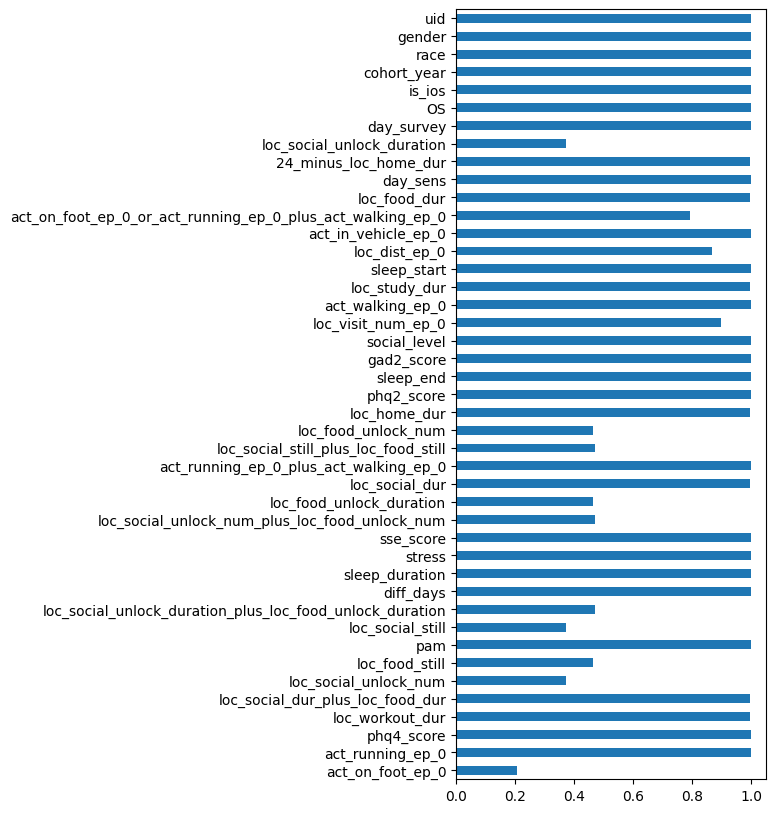

In [125]:
# null rate
ax = (1 - df.isnull().mean()).to_frame().plot.barh(figsize=(4, 10), legend=False)
ax.invert_yaxis()

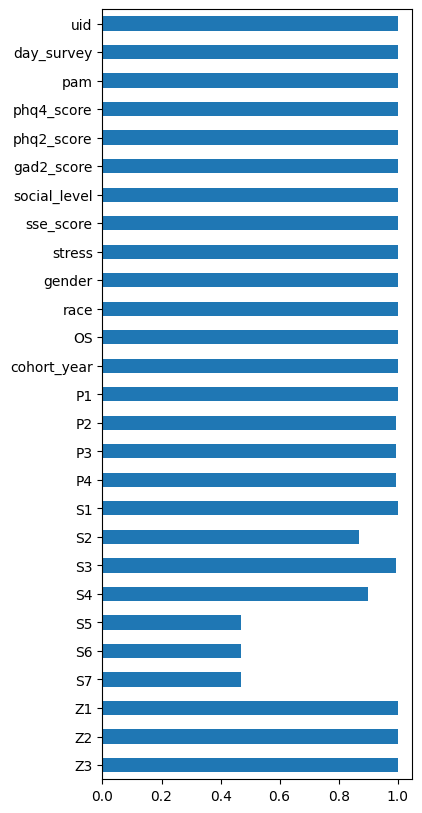

In [126]:
# null rate (after adding)
ax = (1 - df_features.isnull().mean()).to_frame().plot.barh(figsize=(4, 10), legend=False)
ax.invert_yaxis()

In [127]:
check_df = pd.read_csv('features.csv')
check_df

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,3569e2f520db9014b4acc4227a6421c1,2017-09-09,3.0,1.0,0.0,1.0,2.0,16.0,2.0,both,...,561.000000,2767.287472,NaN,6.0,NaN,NaN,NaN,14.500000,0.000000,116.0
1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,3.0,2.0,1.0,1.0,3.0,13.0,2.0,both,...,694.500000,2737.717474,NaN,4.5,NaN,NaN,NaN,8.875000,23.000000,94.0
2,3569e2f520db9014b4acc4227a6421c1,2017-09-14,12.0,1.0,1.0,0.0,2.0,13.0,2.0,both,...,483.166667,5548.611830,1.896759,5.5,45.830066,10.690133,67.645909,6.416667,31.666667,83.0
3,3569e2f520db9014b4acc4227a6421c1,2017-09-18,4.0,1.0,1.0,0.0,3.0,11.0,3.0,both,...,357.500000,7865.060548,1.323502,5.5,34.394523,10.777046,61.982894,5.600000,39.000000,83.8
4,3569e2f520db9014b4acc4227a6421c1,2017-09-22,9.0,1.0,1.0,0.0,4.0,14.0,2.0,both,...,308.000000,8556.029342,1.975143,6.0,34.447041,10.521750,65.976630,5.050000,45.200000,85.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34701,2c4f43b2212eee5ba69563f139911138,2020-12-24,3.0,0.0,0.0,0.0,4.0,15.0,1.0,M,...,3879.700000,67682.634993,0.000000,2.5,NaN,NaN,NaN,5.950000,33.600000,81.2
34702,8617ddac1f48b148e3683738519b2e7a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34703,ea716dd032aaa0dcf8bfa36b1811917f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34704,df5e798581def8d477316520953b9171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
